# Data

In [ ]:
import os
import re
import tarfile
import requests
import torch
import torch.nn as nn
import numpy as np
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def download_imdb(data_path="./imdb"):
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    os.makedirs(data_path, exist_ok=True)
    filepath = os.path.join(data_path, "aclImdb_v1.tar.gz")

    if not os.path.exists(filepath):
        print("Downloading IMDb dataset...")
        r = requests.get(url, stream=True)
        with open(filepath, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024): f.write(chunk)

        print("Extracting...")
        with tarfile.open(filepath, "r:gz") as tar:
            tar.extractall(path=data_path)
    print("Done.")

download_imdb()

def clean_text(text):
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.lower()

def load_imdb_data(base_path, split='train'):
    data = []
    for label in ['pos', 'neg']:
        folder = os.path.join(base_path, f'aclImdb/{split}/{label}')
        for fname in os.listdir(folder):
            with open(os.path.join(folder, fname), 'r', encoding='utf8') as f:
                text = clean_text(f.read())
                data.append((text, 1 if label == 'pos' else 0))
    return data

train_raw = load_imdb_data("./imdb", split='train')
test_raw = load_imdb_data("./imdb", split='test')

Extracting...
Done.


In [ ]:
def tokenize(text):
    return text.split()

# Build vocab
counter = Counter()
for text, _ in train_raw:
    counter.update(tokenize(text))

vocab = {"<pad>": 0, "<unk>": 1}
for word, freq in counter.items():
    if freq >= 5:
        vocab[word] = len(vocab)

def encode(text):
    return [vocab.get(w, vocab["<unk>"]) for w in tokenize(text)]

class IMDBDataset(Dataset):
    def __init__(self, data):
        self.data = [(encode(text), label) for text, label in data]
    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx]

def collate_fn(batch):
    texts, labels = zip(*batch)
    texts = [torch.tensor(x) for x in texts]
    texts = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=vocab["<pad>"])
    return texts.to(device), torch.tensor(labels).to(device)

train_dataset = IMDBDataset(train_raw)
test_dataset = IMDBDataset(test_raw)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)


# Model

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        # Create a long enough P×d_model matrix once, then slice in forward
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()            # (max_len, 1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model)
        )                                                                   # (d_model/2,)

        # Apply sin to even dimensions; cos to odd dimensions
        pe[:, 0::2] = torch.sin(position * div_term)                        # even indices
        pe[:, 1::2] = torch.cos(position * div_term)                        # odd indices

        # Register as buffer so it's moved to device with the module, but not trained
        self.register_buffer('pe', pe.unsqueeze(0))                         # (1, max_len, d_model)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, d_model]
        Returns:
            x + positional encodings: shape [batch_size, seq_len, d_model]
        """
        seq_len = x.size(1)
        # add positional encoding (automatically on same device and dtype)
        return x + self.pe[:, :seq_len]


In [5]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"

        # Linear projections for Q, K, V
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)

        # Final output projection
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, key_padding_mask=None):
        """
        query, key, value:     (seq_len, batch_size, embed_dim)
        key_padding_mask:      (batch_size, seq_len_key) with True in positions to mask
        """
        seq_len, batch_size, _ = query.size()

        # 1) Linear projections + reshape for multi-head
        #    -> (seq_len, batch_size * num_heads, head_dim), then transpose to (batch_size*num_heads, seq_len, head_dim)
        q = self.q_proj(query) \
               .view(seq_len, batch_size, self.num_heads, self.head_dim) \
               .permute(1, 2, 0, 3) \
               .reshape(batch_size * self.num_heads, seq_len, self.head_dim)
        k = self.k_proj(key) \
               .view(-1, batch_size, self.num_heads, self.head_dim) \
               .permute(1, 2, 0, 3) \
               .reshape(batch_size * self.num_heads, -1, self.head_dim)
        v = self.v_proj(value) \
               .view(-1, batch_size, self.num_heads, self.head_dim) \
               .permute(1, 2, 0, 3) \
               .reshape(batch_size * self.num_heads, -1, self.head_dim)

        # 2) Scaled dot-product attention
        attn_output, attn_weights = self.scaled_dot_product_attention(
            q, k, v, key_padding_mask, batch_size
        )

        # 3) Reshape back: (batch_size*num_heads, seq_len, head_dim) ->
        #    (batch_size, num_heads, seq_len, head_dim) -> (seq_len, batch_size, embed_dim)
        attn_output = attn_output \
            .view(batch_size, self.num_heads, seq_len, self.head_dim) \
            .permute(2, 0, 1, 3) \
            .contiguous() \
            .view(seq_len, batch_size, self.embed_dim)

        # 4) Final linear projection
        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights

    def scaled_dot_product_attention(self, q, k, v, key_padding_mask, batch_size):
        """
        q, k, v:  (batch_size*num_heads, seq_len, head_dim)
        key_padding_mask: (batch_size, seq_len_k)
        Returns:
          output:        (batch_size*num_heads, seq_len_q, head_dim)
          attn_weights:  (batch_size, num_heads, seq_len_q, seq_len_k)
        """
        # 1) raw scores
        dk = self.head_dim
        scores = torch.bmm(q, k.transpose(1, 2)) / math.sqrt(dk)  # (B*H, Lq, Lk)

        # 2) apply key padding mask if provided
        if key_padding_mask is not None:
            # expand mask to (batch_size, num_heads, 1, seq_len_k)
            # then broadcast to (batch_size*num_heads, seq_len_q, seq_len_k)
            mask = key_padding_mask.unsqueeze(1) \
                                    .unsqueeze(2)       \
                                    .expand(batch_size, self.num_heads, scores.size(1), scores.size(2))
            mask = mask.reshape(-1, scores.size(1), scores.size(2))
            scores = scores.masked_fill(mask, float('-inf'))

        # 3) attention weights
        attn_weights = F.softmax(scores, dim=-1)  # (B*H, Lq, Lk)
        attn_weights = self.dropout(attn_weights)

        # 4) weighted sum
        output = torch.bmm(attn_weights, v)       # (B*H, Lq, head_dim)

        # reshape weights to (batch_size, num_heads, Lq, Lk) for returning
        attn_weights = attn_weights.view(
            batch_size, self.num_heads, scores.size(1), scores.size(2)
        )

        return output, attn_weights


In [6]:
import torch.nn.functional as F

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.self_attn = MultiheadAttention(d_model, nhead, dropout=dropout)
        # Feed-forward network
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        # Layer norms & dropouts for the two sub-layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        # --- 1) Self-attention sub-layer ---
        # src: (seq_len, batch_size, d_model)
        src2, _ = self.self_attn(src, src, src)
        # Add & norm
        src = src + self.dropout1(src2)
        src = self.norm1(src)

        # --- 2) Feed-forward sub-layer ---
        # FFN: Linear → ReLU → Dropout → Linear
        ff = self.linear2(self.dropout(F.relu(self.linear1(src))))
        # Add & norm
        src = src + self.dropout2(ff)
        src = self.norm2(src)

        return src


In [7]:
class TransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([copy.deepcopy(encoder_layer) for _ in range(num_layers)])

    def forward(self, src):
        """
        Args:
            src: Tensor of shape (seq_len, batch_size, d_model)
        Returns:
            output: Tensor of same shape after passing through all layers
        """
        output = src
        for layer in self.layers:
            output = layer(output)
        return output


In [15]:
import math

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, num_layers=2, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward=d_model*2, dropout=0.1)
        self.transformer = TransformerEncoder(encoder_layer, num_layers)

        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, src):
        """
        Args:
            src: LongTensor of shape (batch_size, seq_len)
        Returns:
            logits: Tensor of shape (batch_size, num_classes)
        """
        # 1) Embed and scale
        #    -> (batch_size, seq_len, d_model)
        x = self.embedding(src) * math.sqrt(self.embedding.embedding_dim)

        # 2) Add positional encoding
        #    (batch_size, seq_len, d_model)
        x = self.pos_encoder(x)

        # 3) Transpose for transformer: (seq_len, batch_size, d_model)
        x = x.transpose(0, 1)

        # 4) Pass through the stacked encoder
        #    output shape: (seq_len, batch_size, d_model)
        x = self.transformer(x)

        # 5) Classification head on the first token (like [CLS])
        #    x[0]: (batch_size, d_model)
        return self.fc(x[0])

# Instantiate and move to device
model = TransformerClassifier(len(vocab)).to(device)


# Train

In [16]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0

    for x, y in loader:
        optimizer.zero_grad()
        out = model(x)                      # (batch_size, num_classes)
        loss = criterion(out, y)            # scalar
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == y).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy

def evaluate(model, loader):
    model.eval()
    correct = 0

    with torch.no_grad():
        for x, y in loader:
            out = model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()

    accuracy = correct / len(loader.dataset)
    return accuracy


In [10]:
num_epochs = 5
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    test_acc = evaluate(model, test_loader)
    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch 01 | Train Loss: 0.5718 | Train Acc: 0.7058 | Test Acc: 0.7549
Epoch 02 | Train Loss: 0.4815 | Train Acc: 0.7762 | Test Acc: 0.7910
Epoch 03 | Train Loss: 0.4374 | Train Acc: 0.8014 | Test Acc: 0.7966
Epoch 04 | Train Loss: 0.3988 | Train Acc: 0.8226 | Test Acc: 0.8092
Epoch 05 | Train Loss: 0.3677 | Train Acc: 0.8425 | Test Acc: 0.8156


# Evaluation

In [11]:
# Make sure model is on eval mode
model.eval()

# Number of examples to display
n_examples = 5

for i in range(n_examples):
    # Get raw text and true label from test_raw
    text, true_label = test_raw[i]

    # Encode & convert to tensor, add batch dim
    encoded = torch.tensor(encode(text), device=device).unsqueeze(0)

    # Forward pass
    with torch.no_grad():
        logits = model(encoded)
        pred_label = logits.argmax(dim=1).item()

    # Map 0/1 back to neg/pos
    label_str = lambda l: "positive" if l == 1 else "negative"

    print(f"Example #{i+1}")
    print("─" * 80)
    print(f"Review snippet: {text[:300]}{'...' if len(text)>300 else ''}\n")
    print(f"True label:      {label_str(true_label)}")
    print(f"Predicted label: {label_str(pred_label)}\n")


Example #1
────────────────────────────────────────────────────────────────────────────────
Review snippet: i hope from his seat on heavens comedic throne spike milligan can see and can enjoy this film as terence ryan and ken tuohy have taken a book that the author himself said writing it nearly turned me mad into a joy to watchthe film tells the story of the irish town of puckoon and the problems befalle...

True label:      positive
Predicted label: positive

Example #2
────────────────────────────────────────────────────────────────────────────────
Review snippet: the romanian cinema is little known out of romania no directors from romania came out to the attention of the international public as some from other countries from eastern europe like hungary czekoslowakia or yugoslavia succeeded to do one of the few great directors in romanian cinema is lucian pin...

True label:      positive
Predicted label: positive

Example #3
─────────────────────────────────────────────────────────

# Experiment with different model hyperparameters

Best config: d_model=32, nhead=2, num_layers=2, lr=0.001 → Val Acc=0.8468


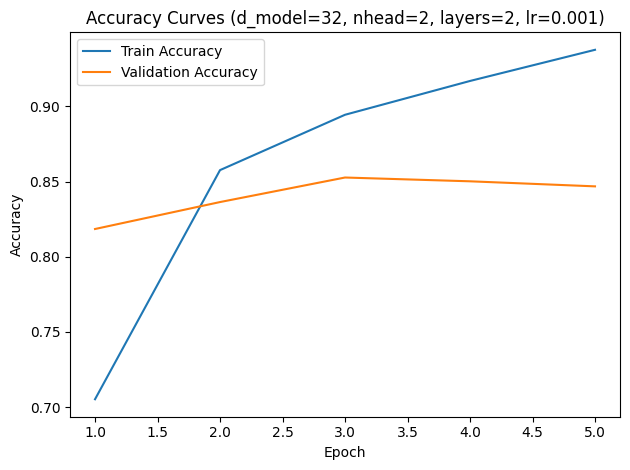

In [14]:
import matplotlib.pyplot as plt

# 1. Define our hyperparameter grid
param_grid = {
    'd_model':     [32],
    'nhead':       [2],
    'num_layers':  [2],
    'lr':          [1e-3]
}

# 2. Sweep: train each combo for a few epochs, record histories
results = []
num_epochs = 5  # how many epochs to train each config for the sweep

for d_model, nhead, num_layers, lr in product(
        param_grid['d_model'],
        param_grid['nhead'],
        param_grid['num_layers'],
        param_grid['lr']
    ):
    if d_model % nhead != 0:
        continue  # skip invalid head configs

    # Instantiate model, optimizer, loss
    model = TransformerClassifier(
        vocab_size=len(vocab),
        d_model=d_model,
        nhead=nhead,
        num_layers=num_layers
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_history, val_history = [], []
    # Train & evaluate for num_epochs
    for epoch in range(1, num_epochs + 1):
        _, train_acc = train(model, train_loader, optimizer, criterion)
        val_acc     = evaluate(model, test_loader)
        train_history.append(train_acc)
        val_history.append(val_acc)

    # Final validation accuracy for ranking
    final_val = val_history[-1]
    results.append({
        'config':      (d_model, nhead, num_layers, lr),
        'train_hist':  train_history,
        'val_hist':    val_history,
        'final_val':   final_val
    })

# 3. Identify best config by final_val
results = sorted(results, key=lambda x: x['final_val'], reverse=True)
best = results[0]
d_model, nhead, num_layers, lr = best['config']

print(f"Best config: d_model={d_model}, nhead={nhead}, "
      f"num_layers={num_layers}, lr={lr} → Val Acc={best['final_val']:.4f}")

# 4. Plot training & validation curves for the best config
epochs = list(range(1, num_epochs+1))
plt.figure()
plt.plot(epochs, best['train_hist'], label='Train Accuracy')
plt.plot(epochs, best['val_hist'],   label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f"Accuracy Curves (d_model={d_model}, nhead={nhead}, layers={num_layers}, lr={lr})")
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, num_layers=2, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward=d_model*2, dropout=0.1)
        self.transformer = TransformerEncoder(encoder_layer, num_layers)

        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, src):
        """
        Args:
            src: LongTensor of shape (batch_size, seq_len)
        Returns:
            logits: Tensor of shape (batch_size, num_classes)
            all_attn: List of attention-weight tensors, each of shape
                      (batch_size, num_heads, seq_len, seq_len)
        """
        # 1) Embed & scale
        x = self.embedding(src) * math.sqrt(self.embedding.embedding_dim)
        # 2) Positional encoding
        x = self.pos_encoder(x)                    # (batch_size, seq_len, d_model)
        # 3) Prepare for transformer: (seq_len, batch_size, d_model)
        x = x.transpose(0, 1)

        all_attn = []
        # 4) Pass through each encoder layer, capturing its self-attn weights
        for layer in self.transformer.layers:
            # Self-attention: returns (output, attn_weights)
            attn_out, attn_w = layer.self_attn(x, x, x)
            all_attn.append(attn_w)                # (batch, heads, seq, seq)

            # Add & norm after attention
            x = layer.norm1(x + layer.dropout1(attn_out))
            # Feed-forward
            ff = layer.linear2(layer.dropout(F.relu(layer.linear1(x))))
            # Add & norm after FFN
            x = layer.norm2(x + layer.dropout2(ff))

        # 5) x is (seq_len, batch_size, d_model); take first token as summary
        cls_token_repr = x[0]                      # (batch_size, d_model)
        logits = self.fc(cls_token_repr)           # (batch_size, num_classes)

        return logits, all_attn

# Setup
model = TransformerClassifier(
    vocab_size=len(vocab),
    d_model=128,
    nhead=4,
    num_layers=2,
    num_classes=2
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    running_correct = 0

    for x, y in loader:
        optimizer.zero_grad()
        logits, _ = model(x)               # ignore attention weights here
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss    += loss.item() * x.size(0)
        preds            = logits.argmax(dim=1)
        running_correct += (preds == y).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = running_correct / len(loader.dataset)
    return epoch_loss, epoch_acc

def eval_epoch(model, loader):
    model.eval()
    running_correct = 0

    with torch.no_grad():
        for x, y in loader:
            logits, _ = model(x)
            preds = logits.argmax(dim=1)
            running_correct += (preds == y).sum().item()

    return running_correct / len(loader.dataset)

# Training loop
num_epochs = 5
for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_acc               = eval_epoch(model, test_loader)
    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Train Acc:  {train_acc:.4f} | "
          f"Val Acc:    {val_acc:.4f}")



Epoch 01 | Train Loss: 0.5580 | Train Acc:  0.7141 | Val Acc:    0.7734
Epoch 02 | Train Loss: 0.4571 | Train Acc:  0.7900 | Val Acc:    0.8017
Epoch 03 | Train Loss: 0.3984 | Train Acc:  0.8268 | Val Acc:    0.8153
Epoch 04 | Train Loss: 0.3652 | Train Acc:  0.8437 | Val Acc:    0.8169
Epoch 05 | Train Loss: 0.3256 | Train Acc:  0.8632 | Val Acc:    0.8231


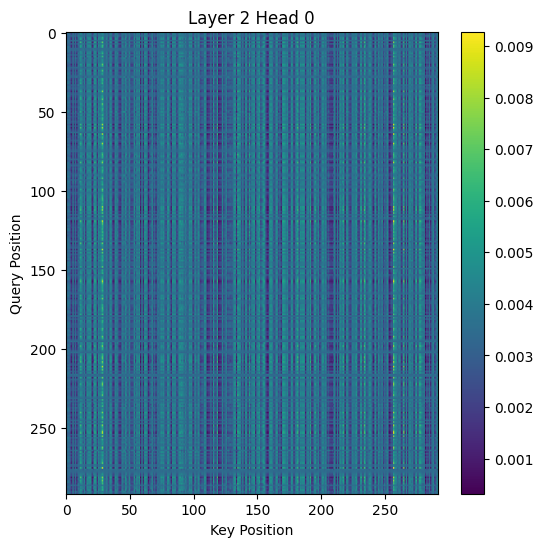

In [21]:
# 2) Sample a test example:
sample_idx = 0
text, _ = test_raw[sample_idx]
input_ids = torch.tensor(encode(text), device=device).unsqueeze(0)
model.eval()
logits, attn_weights = model(input_ids)

# 3) Visualize the first head of the last layer:
import matplotlib.pyplot as plt

weights = attn_weights[-1][0, 0].detach().cpu().numpy()  # (seq_len, seq_len)
plt.figure(figsize=(6,6))
plt.imshow(weights, aspect='auto')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.title('Layer {} Head {}'.format(len(attn_weights), 0))
plt.colorbar()
plt.show()